In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers


Using TensorFlow backend.


In [2]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
import plotly.plotly as py
init_notebook_mode(connected=True)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [3]:
from google.colab import files
from google.colab import drive


drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_path = os.path.join("/content/gdrive/My Drive", "Colab Notebooks/data/")
dataset_path = os.path.join(data_path, "data_hackathon_v04.csv")
dataset_time_path = os.path.join(data_path, "data_hackathon_time.csv")
dataset_labeled_path = os.path.join(data_path, "labeled_data.csv")
distridt_time_path = os.path.join(data_path, "districts_time_data.csv")


In [5]:
df = pd.read_csv(distridt_time_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072783 entries, 0 to 1072782
Data columns (total 21 columns):
Unnamed: 0            1072783 non-null int64
Unnamed: 0.1          1072783 non-null int64
ride_id               1072783 non-null object
created_at            1072783 non-null object
pickup_lat            1072783 non-null float64
pickup_lng            1072783 non-null float64
dropoff_lat           1072783 non-null float64
dropoff_lng           1072783 non-null float64
user_id               1072783 non-null object
driver_id             956744 non-null object
ride_distance         1072783 non-null float64
canceled_by_client    1072783 non-null int64
canceled_by_driver    1072783 non-null int64
ride_to_suburb        1072783 non-null int64
month                 1072783 non-null int64
month_day             1072783 non-null int64
week_day              1072783 non-null int64
hour                  1072783 non-null int64
pickup_district       1072783 non-null object
dropoff_district  

In [6]:
df.head()

,Unnamed: 0,Unnamed: 0.1,ride_id,created_at,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,user_id,driver_id,...,canceled_by_client,canceled_by_driver,ride_to_suburb,month,month_day,week_day,hour,pickup_district,dropoff_district,time
0,0,0,000002b3a3014388a6c62fdda1d03de1n,2018-12-14 23:00:00.043,49.824671,24.013246,49.784729,24.060303,3900450045004500300042003700310037003800460031...,a429c637c1244bb7a1d606d2b9987bdd,...,0,0,0,12,14,4,23,871e7689cffffff,871e76135ffffff,2018-12-14 23:00:00
1,1,1,000013de085e4be4a2cd27d9112f7bdbn,2018-10-13 23:59:00.580,49.837906,24.029772,49.841217,23.974363,6227785C7862375C7863623F5C7866652E285F2D5C7861...,NaN,...,1,0,0,10,13,5,23,871e76883ffffff,871e76891ffffff,2018-10-14 00:00:00
2,2,2,000040911549444d8ad461c69370e883n,2018-08-25 21:40:52.537,49.839718,23.994425,49.840610,24.029135,62277C6C5C7866386C572C795C7838315C7831645C7863...,7323767ede0349d1a7bfe743a091d63c,...,0,0,0,8,25,5,21,871e76882ffffff,871e76883ffffff,2018-08-25 22:00:00
3,3,3,0000759fc38a410e8d8802610800ccacn,2018-12-08 13:43:41.357,49.829708,24.044172,49.869137,24.010246,62275C7864335C78393135635C6E5C7830355C7839645C...,NaN,...,1,0,0,12,8,5,13,871e7689dffffff,871e76880ffffff,2018-12-08 14:00:00
4,4,4,0000e61e5282484d943291df7266ee33n,2019-01-18 09:18:44.377,49.837013,24.034357,49.832710,23.999216,3300360037004600420041003600300032003500410033...,2913413c2bf748d7932d1d587c8aef13,...,0,0,0,1,18,4,9,871e76883ffffff,871e7689cffffff,2019-01-18 09:00:00


In [7]:
districts_ids = df["pickup_district"].unique()
n_districts = len(df["pickup_district"].unique())
print("Districts number =", n_districts)
districts_demand = [len(df[df.pickup_district == i]) for i in districts_ids]


Districts number = 45


No handles with labels found to put in legend.


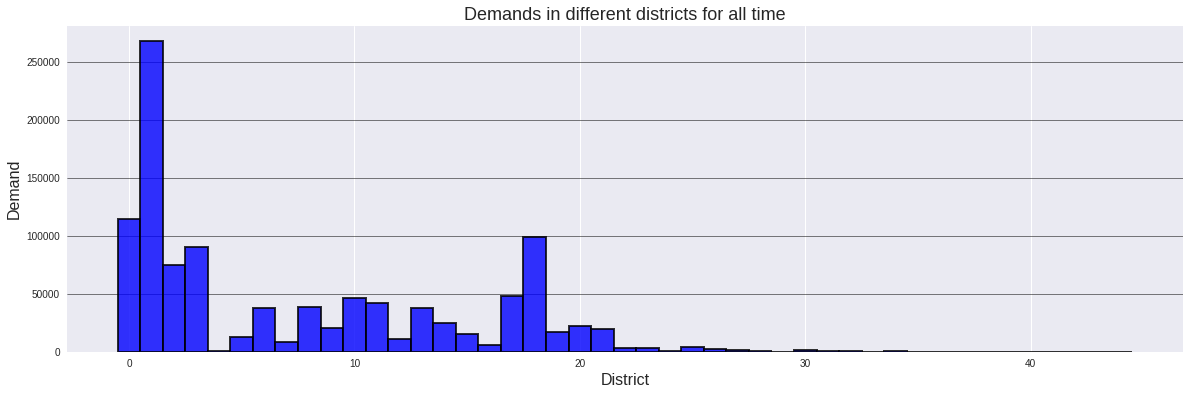

In [8]:
index = np.arange(n_districts)

fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(index , height=districts_demand, width=1, alpha=0.8,
       color="b", edgecolor="black", linewidth=2)

ax.set_title("Demands in different districts for all time", fontsize=18)
ax.set_ylabel("Demand", fontsize=16)
ax.set_xlabel("District", fontsize=16)
ax.legend(loc=0, fontsize=16)

ax.grid(axis="y", color="black", linewidth=0.5)
plt.show()

In [0]:
# df.created_at = df.created_at.apply(pd.to_datetime)
# df['time'] = df['created_at'].apply(lambda x: pd.Timestamp.round(x,'h'))
# df.to_csv(distridt_time_path)

In [0]:
rand_seed = 100
np.random.seed(rand_seed)
window = 360 # 720 # in houres
step = 1

def print_shapes(arrays, arr_names=[]):
    """
    Print shapes of numpy arrays or length of lists.
    :param list of np.ndarrays or lists arrays:
    :param list of str arr_names:
    """
    for i, array in enumerate(arrays):
        if len(arr_names) > i:
            arr_name = arr_names[i]
        else:
            arr_name = ""
        try:
            print(i + 1, arr_name, "shape =", array.shape, "Type =",
                  type(array), "Dtype =", array.dtype)
        except AttributeError:
            print(i + 1, arr_name, "shape =", len(array), "Type =",
                  type(array), "Elements type =", type(array[0]))
                 
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
  
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]
    return X_train, X_test, Y_train, Y_test
  
def get_dnn():
    model = Sequential()
    model.add(Dense(64, input_dim=window))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dense(1))
    model.add(Activation('linear'))

    model.compile(optimizer=Nadam(0.001), 
                  loss = 'mse',
                  metrics=['mae'])
    return model
  
def plot_logs(history):
    keys = list(history.history.keys())
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    ax[0].plot(history.history[keys[1]], label=keys[1],
            color="blue", linewidth=3)
    ax[0].plot(history.history[keys[3]], label="Train " + keys[3],
            color="red", linewidth=3)
    ax[0].set(xlabel="epoch", ylabel=keys[1])
    ax[0].legend(loc=0, fontsize=15)
    ax[0].grid()
    
    ax[1].plot(history.history["loss"], label="Train loss", 
               color="blue", linewidth=3)
    ax[1].plot(history.history["val_loss"], label="Val loss",
               color="red", linewidth=3)
    ax[1].legend(loc=0, fontsize=15)
    ax[1].set_xlabel("epoch", fontsize=16)
    ax[1].set_ylabel("loss", fontsize=16)
    ax[1].grid()
    
    plt.show()
    
def plot_diagram(counts, means, title="Errors"):
  index = np.arange(len(counts))

  fig, ax = plt.subplots(figsize=(20, 6))
  ax.bar(index - 0.4, height=counts, width=0.4, alpha=0.8, label = "Error",
         color="red", edgecolor="black", linewidth=2)
  
  ax.bar(index, height=means, width=0.4, color="blue",
       label="Mean", alpha=0.8, edgecolor="black", linewidth=2)
  
  ax.set_title(title, fontsize=18)
  ax.set_ylabel("Error", fontsize=16)
  ax.set_xlabel("District", fontsize=16)
  ax.legend(loc=0, fontsize=16)
  
  ax.grid(axis="y", color="black", linewidth=0.5)
  plt.show()
  
  
def get_df_all_dates_old(df_grouped):
  start_time = np.min(df_grouped.time)
  end_time = np.max(df_grouped.time)
  
  time_index = pd.date_range(start=start_time, end=end_time, freq="H")
  new_df = pd.DataFrame({"time": time_index,
                         "demand": np.zeros(len(time_index))
                        })

  for i, row in new_df.iterrows():
    for j, _ in df_grouped.iterrows():
      if new_df.loc[i, "time"] == df_grouped.loc[j, "time"]:
        new_df.loc[i, "demand"] = int(df_grouped.loc[j, "demand"])
        break
        
  return new_df


def get_df_all_dates(df_grouped):
  
  start_time = np.min(df_grouped.time)
  end_time = np.max(df_grouped.time)
  
  time_index = pd.date_range(start=start_time, end=end_time, freq="H")
  new_df = pd.DataFrame({"time": time_index})

  s=[]
  t = df_grouped.index.tolist()
  right = new_df.index.tolist()
  for time in right:
      if time in t:
          s.append(df_grouped.loc[time].demand)
      else:
          s.append(0)
  new_df['demand'] = s
  return new_df

In [14]:
%%time

window = 360 # 720 # in houres
step = 1

mae = []
mse = []
mean_demands = []
list_X = []
histories = []
models = []
predicts = []
X_districts = []
Y_districts = []


for i in range(0, 22):

  
  district_df = df[df.pickup_district == districts_ids[i]]
  district_df = pd.DataFrame(district_df['ride_id'].groupby(district_df.time,).count())
  district_df = district_df.rename(columns={"ride_id": "demand"}, index=str)
  district_df = district_df.reset_index()
  district_df.time = district_df.time.astype('datetime64[ns]')
  district_df = get_df_all_dates(district_df)
  
 #  print(len(district_df), "---------")
 # print(len(district_df[district_df.demand == 0]))
  hours = 1
  
  X, Y = [], []
  for i in range(0, len(district_df), step): 
    try:
        x_i = list(district_df.demand[i: i + window])
        y_i = list(district_df.demand[i + window: i + window + hours])  
        if len(x_i) != window or len(y_i) != hours:
          continue
        
    except Exception as e:
        print(e)
        break
    X.append(x_i)
    Y.append(y_i)
    
  X, Y = np.array(X), np.array(Y)
  
  X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, 0.80)
  # print_shapes([X_train, X_test, Y_train, Y_test])
  
  model = get_dnn()
  history = model.fit(X_train, Y_train, 
          epochs = 150, 
          batch_size = 128, 
          verbose=0, 
          validation_data=(X_test, Y_test),
          shuffle=True,
          )
  models.append(model)
  histories.append(histories)
  scores = model.evaluate(X_test, Y_test)
  mae.append(scores[1])
  mse.append(scores[0])
  mean_demands.append(Y.mean())
  predicts.append(model.predict(X_test))
  X_districts.append(X_test)
  Y_districts.append(Y_test)
  
 # plot_logs(history)
  

815/815 [==============================] - 0s 58us/step
CPU times: user 11min 53s, sys: 1min 15s, total: 13min 8s
Wall time: 9min 36s


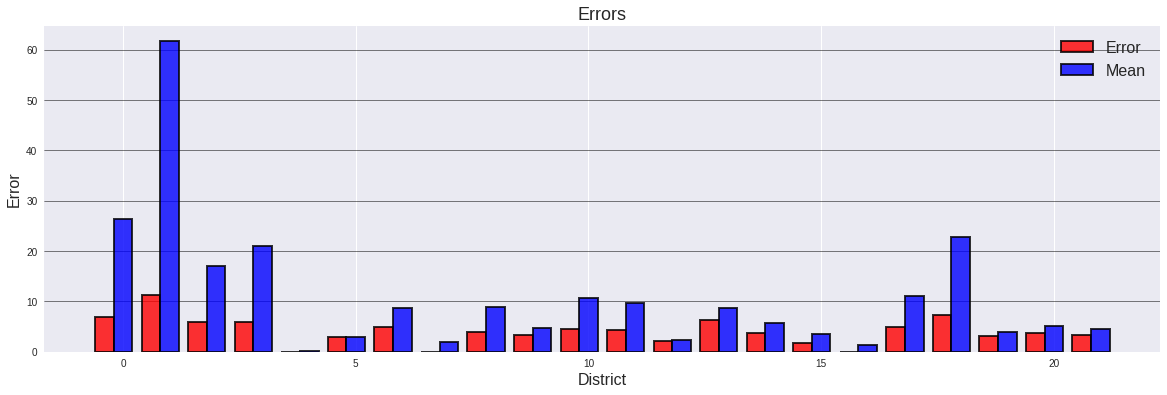

In [15]:
plot_diagram(mae, mean_demands)

In [16]:
mae[:20]

[6.860734036217438,
 11.281545218953326,
 5.95092440002535,
 5.879973451345244,
 0.00975903868675232,
 2.9372485160827635,
 4.991329514907181,
 0.017222169786691666,
 4.001235331201846,
 3.327483239495681,
 4.5693354033253675,
 4.2611579883318,
 2.0694901829116916,
 6.2433773110980635,
 3.7019988526595884,
 1.6725300143832809,
 0.024033293157797606,
 4.846894748079265,
 7.371046850286379,
 3.196480522272777]

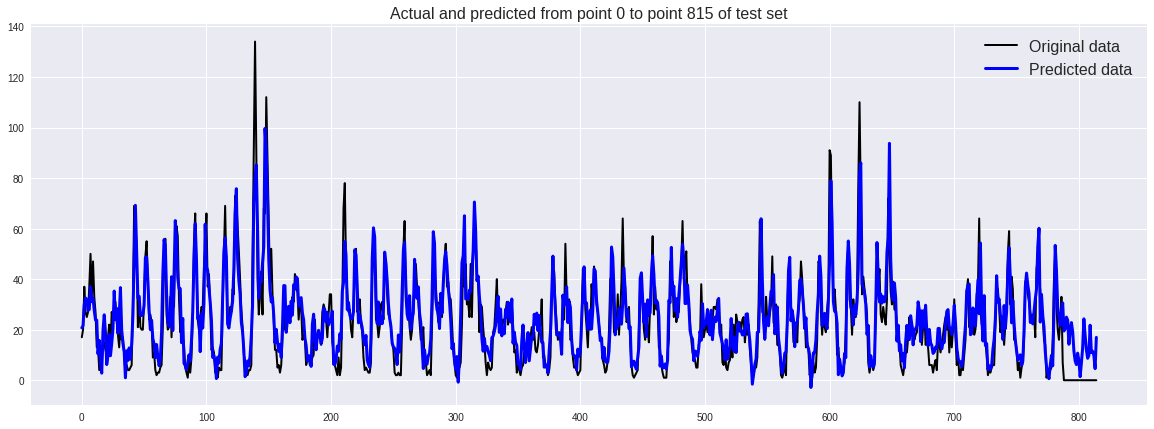

In [17]:
district = 0

pred = models[district].predict(np.array(X_districts[district]))

FROM = 0
TO = FROM + len(pred)

original = Y_districts[district][FROM:TO]
predicted = pred[FROM:TO]

fig, ax = plt.subplots(figsize=(20, 7))

ax.plot(original, color='black', label = 'Original data', linewidth=2, ls='-')
ax.plot(predicted, color='blue', label = 'Predicted data', linewidth=3, ls='-')
ax.legend(loc=0, fontsize=16)
ax.set_title('Actual and predicted from point %d to point %d of test set' % (FROM, TO), fontsize=16)
plt.show()
